In [1]:
import geopandas as gpd
import contextily as cx
import os
import pathlib
import glob
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.crs import CRS
import rioxarray as rxr
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

In [85]:
import matplotlib as mpl

### The Effect of Climate Change on the Species Composition of Maine Forests

#### Data

Temperature Data:

Gridded Surface Meterological Dataset (gridMET), accessed via Climate Engine
- Mean annual air temperature for 1979-present at 4km resolution.

NOAA National Centers for Environmental Information
- Annual mean temperature for each county from 1970-2022.

Forest Cover Data:




In [115]:
nb_path = pathlib.Path().resolve()

In [5]:
nb_path

WindowsPath('C:/Users/roseh/Desktop/785/forest_comp')

#### Study Area

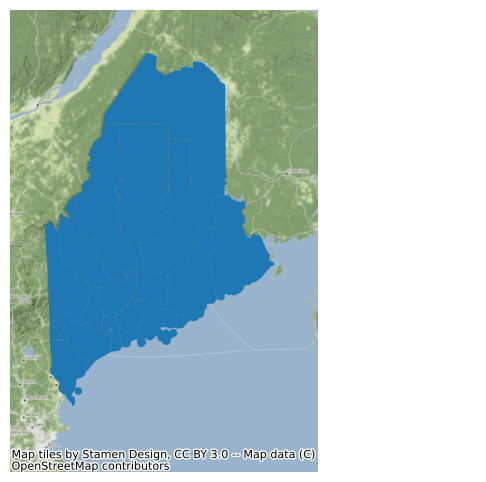

In [30]:
filepath = nb_path / 'data' / 'maine' / 'Maine_County_Boundary_Polygons_Dissolved_Feature.shp'

maine = gpd.read_file(filepath)  # read in Maine shapefile


maine_3857 = maine.to_crs("EPSG:3857")  # reproject to Web Mercator

maine_map = cx.Place('Maine')          # define Maine basemap


fig,ax = plt.subplots(figsize=(4,6))    # plot shapefile on basemap
maine_map.plot(ax=ax)
maine_3857.plot(ax=ax)
ax.axis('off')
plt.show()

### How has Maine's Climate Changed in Recent Years?

In [6]:
filepath = nb_path / 'data' / 'temps'    # set filepath

In [14]:
 # read in and open raster files with no data values masked and reduced to 2-d
all_files = [rxr.open_rasterio(i, masked=True).squeeze() for i in glob.glob(os.path.join(filepath,'*tmean.tif'))]

In [15]:
web_mercator = CRS.from_string('EPSG:3857')   # create crs object

all_files_3857 = [file.rio.reproject(web_mercator) for file in all_files]    # Reproject all files using the crs object

In [16]:
temps_1980, temps_1990, temps_2000, temps_2010, temps_2020 = all_files_3857  # unpack reprojected files

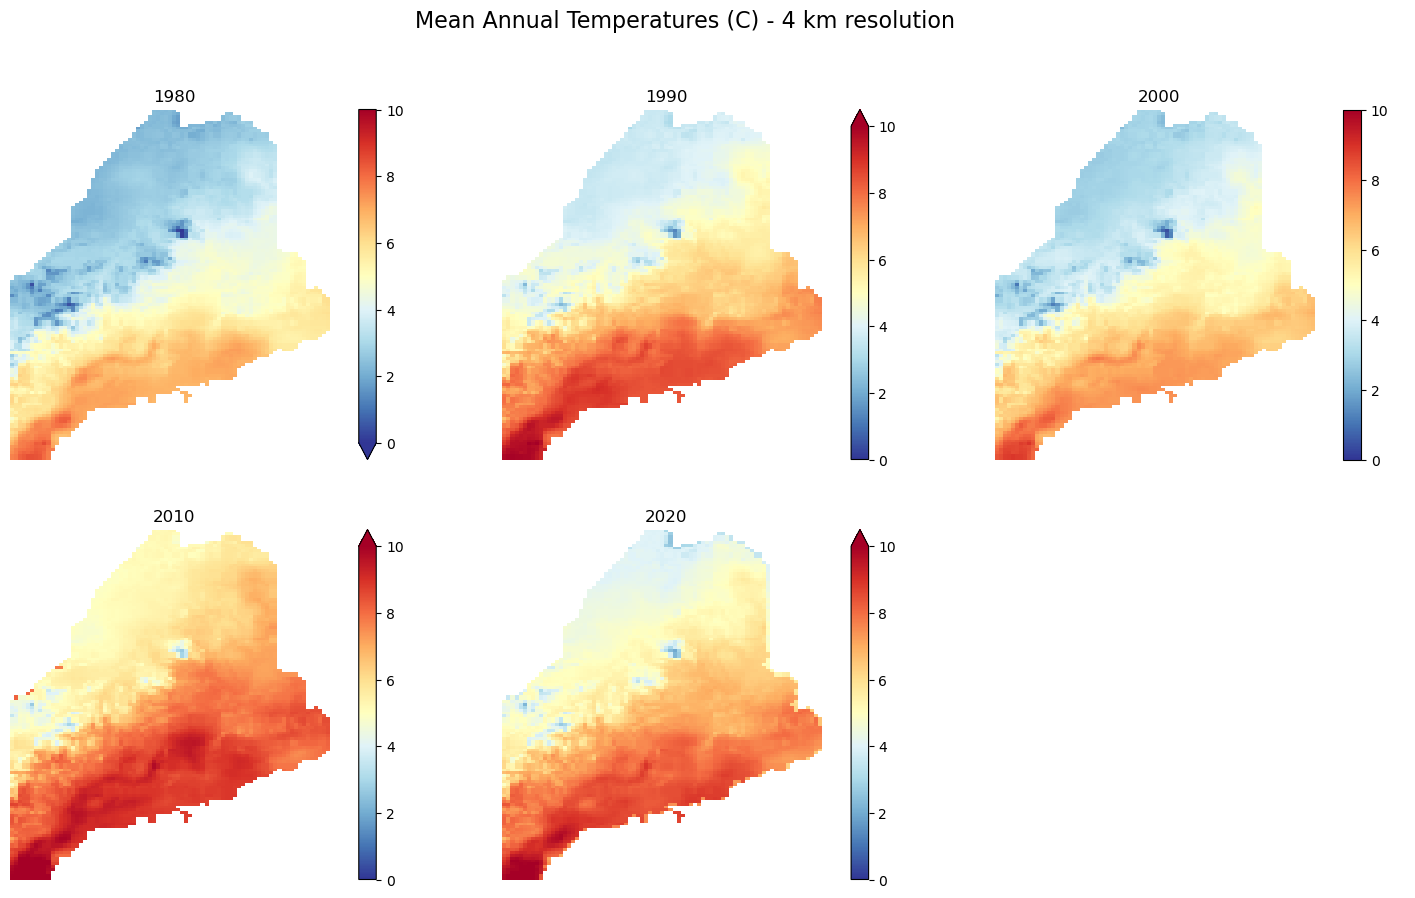

In [26]:
# show map of the air temperature for each year

fig, ax = plt.subplots(2,3,figsize=(18,10))
fig.suptitle('Mean Annual Temperatures (C) - 4 km resolution', fontsize=16)

temps_1980.plot(ax=ax[0][0], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[0][0].set_title('1980')
ax[0][0].axis('off')

temps_1990.plot(ax=ax[0][1], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[0][1].set_title('1990')
ax[0][1].axis('off')

temps_2000.plot(ax=ax[0][2], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[0][2].set_title('2000')
ax[0][2].axis('off')

temps_2010.plot(ax=ax[1][0], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[1][0].set_title('2010')
ax[1][0].axis('off')

temps_2020.plot(ax=ax[1][1], cmap='RdYlBu_r', vmin=0, vmax=10)
ax[1][1].set_title('2020')
ax[1][1].axis('off')

ax[1][2].axis('off')

plt.show()

In [38]:
county_temps = pd.read_csv(os.path.join(filepath, 'all_county_temps_formatted.csv'))

county_temps_grouped = county_temps.groupby('County')   # group dataframe by county
counties = [i for i in county_temps['County'].unique()]   # create list of county names

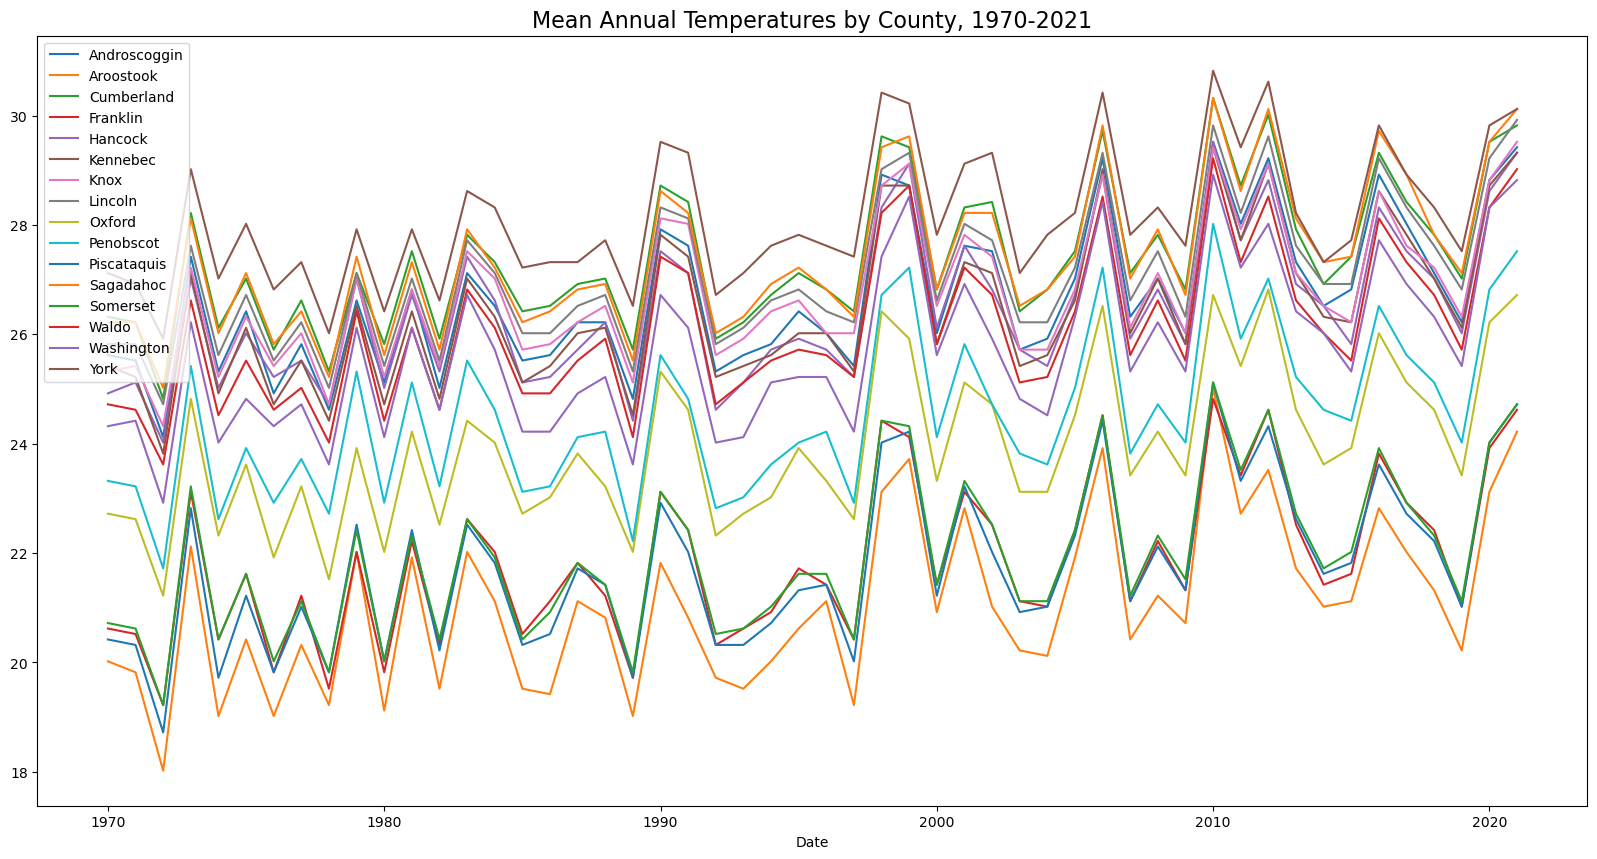

In [50]:
# plot mean annual temperatures over time for each county

fig, ax = plt.subplots(figsize=(20,10))

for county in counties:                                                   # loop through county groups and plot temps on same axis
    county_temps_grouped.get_group(county).plot(x='Date',y='Value',ax=ax)
ax.legend(counties, loc='upper left')

plt.title('Mean Annual Temperatures by County, 1970-2021', fontsize=16)
plt.show()

### How Does Temperature Influence the Populations of Different Tree Species?

In [94]:
forest_2021_temps = pd.read_csv(os.path.join(filepath,'2021_forest_cover_w_50yr_mean_temps.csv'))

In [95]:
# rename and reformat columns for regression
forest_2021_temps.rename(columns={'50_yr_mean_temp':'mean_temp', 'Northern white-cedar': 'Northern_white_cedar'}, inplace=True)
forest_2021_temps.columns = forest_2021_temps.columns.str.replace(' ', '_')
forest_2021_temps.head()

,COUNTY,County_code_and_name,Total,Red_pine,Eastern_white_pine,Balsam_fir,White_spruce,Black_spruce,Tamarack,Northern_white_cedar,Oak,Northern_hardwoods,Lowland_hardwoods,Aspen,Birch,Balsam_poplar,Non_stocked,Other,mean_temp
0,Androscoggin,23001 ME Androscoggin,195667.0,0.000000,15.939837,0.000000,0.000000,0.000000,0.000000,0.000000,6.134913,45.501285,12.065397,0.638329,0.000000,0.000000,1.488243,18.231996,26.683462
1,Aroostook,23003 ME Aroostook,3855540.0,0.320085,0.319385,18.716548,2.568408,4.722711,1.067529,8.940045,0.000000,37.546803,0.697827,6.763229,3.390809,1.512992,0.201710,13.231973,21.066154
2,Cumberland,23005 ME Cumberland,355284.0,0.000000,37.145776,0.000000,0.000000,0.000000,0.000000,0.000000,17.440414,31.177312,4.884262,1.128675,0.000000,0.000000,0.000000,8.223281,27.402692
3,Franklin,23007 ME Franklin,1012749.0,0.147618,2.256630,10.544172,0.669169,0.669169,0.000000,3.249078,0.000000,54.583120,0.475834,8.293763,9.314055,0.000000,0.184942,9.612550,21.864231
4,Hancock,23009 ME Hancock,896019.0,0.000000,8.650040,9.528704,0.792506,7.348951,0.239727,4.326248,2.920362,33.001086,2.601954,3.636642,2.005203,0.000000,0.000000,24.948690,26.439231


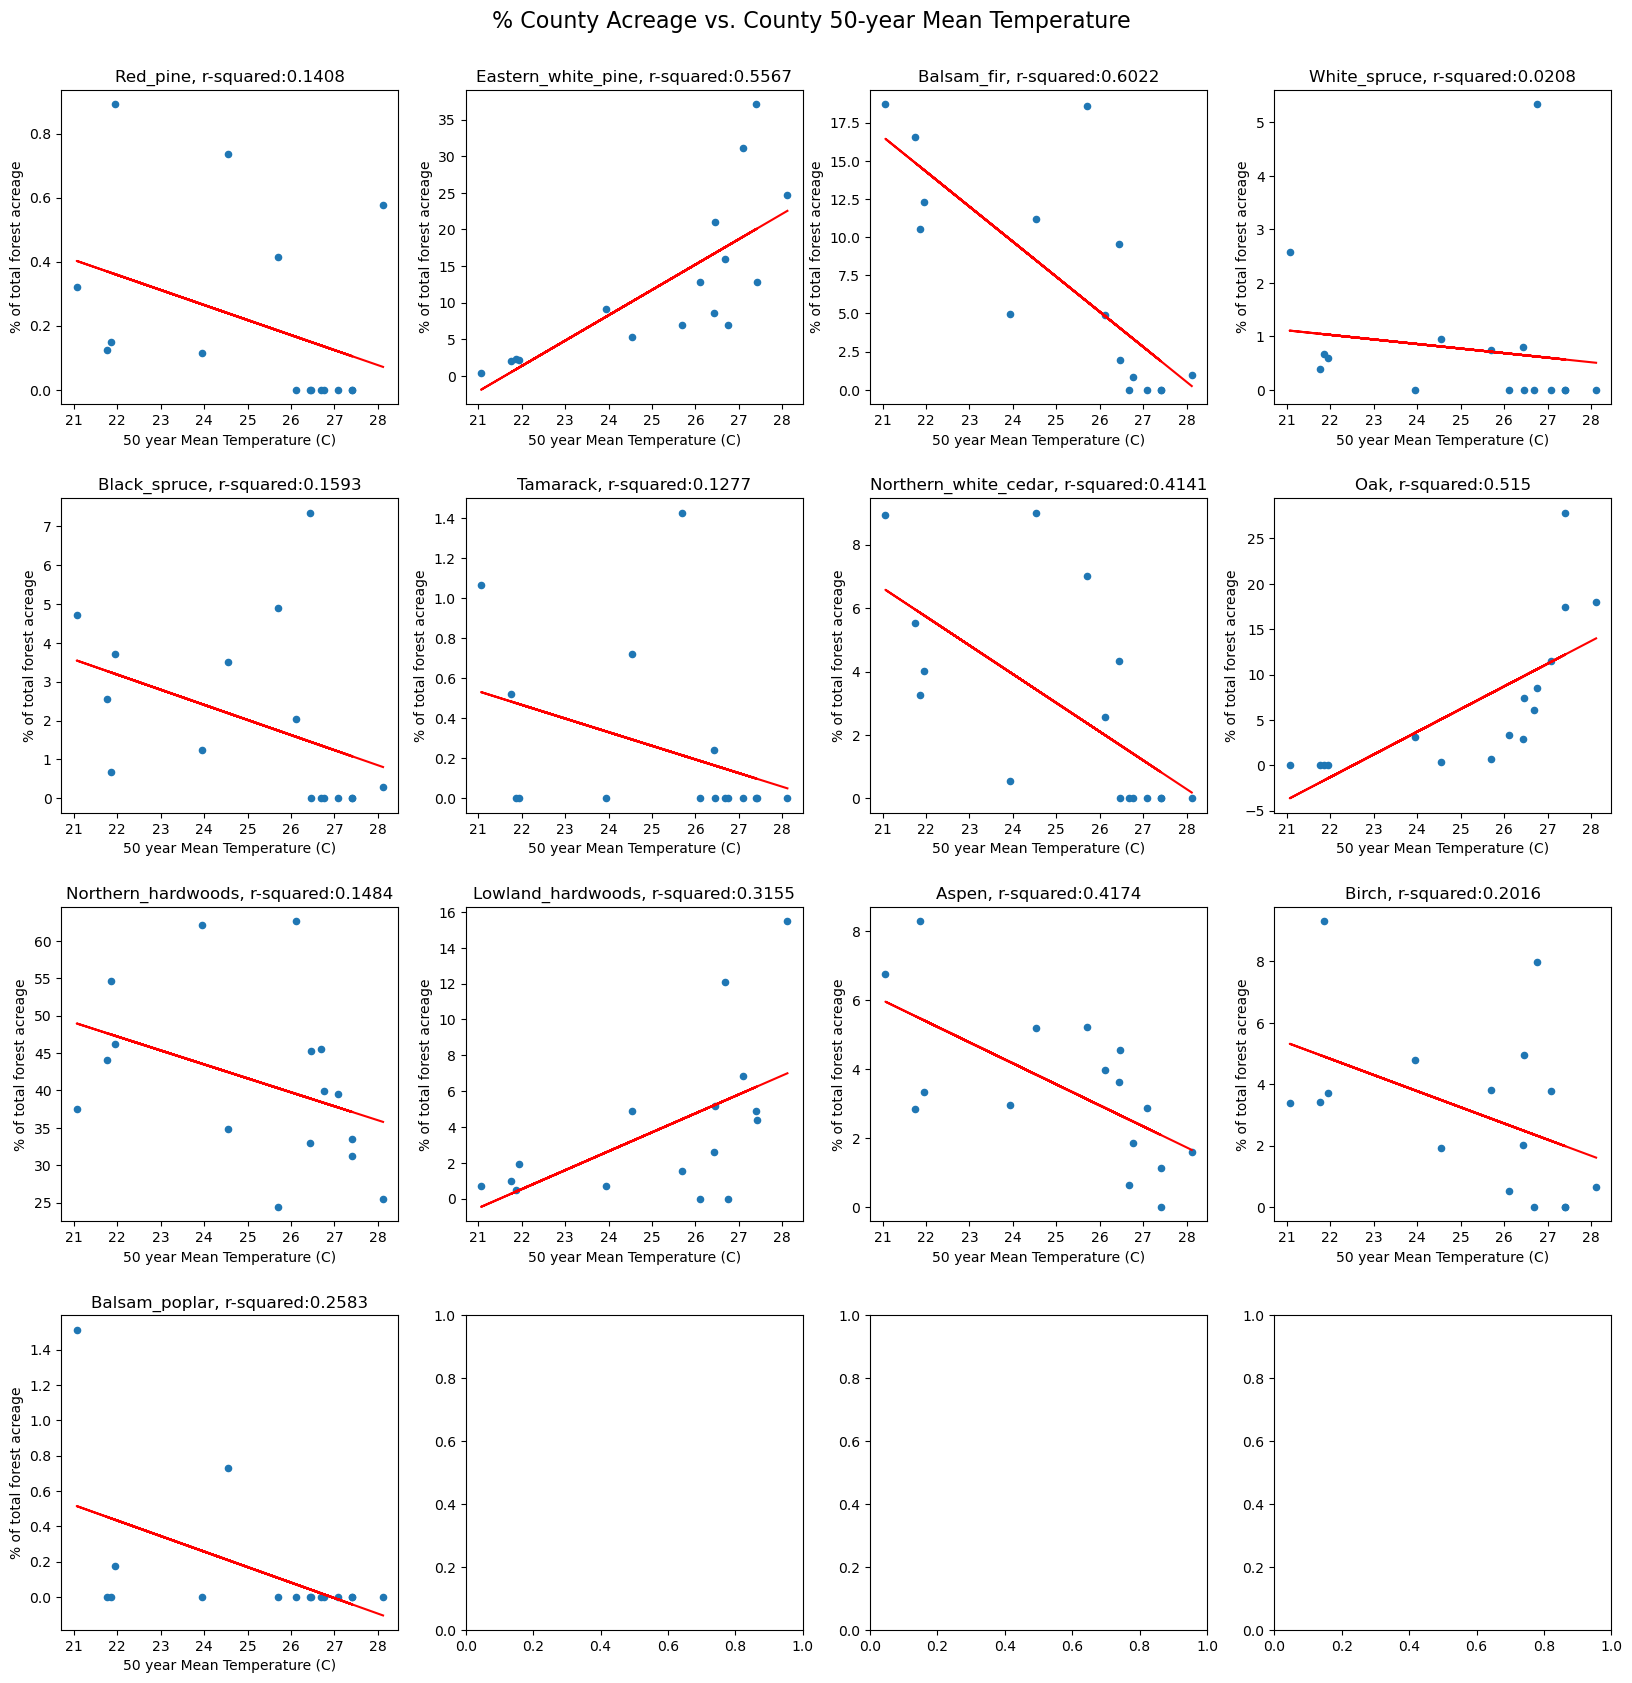

In [98]:
# plot the relationship between temperature and species proportion for each species

fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(20,20))                                
fig.suptitle('% County Acreage vs. County 50-year Mean Temperature', fontsize=16, y=.92)
plt.subplots_adjust(hspace=0.3)

species = forest_2021_temps.columns[3:16]         # define list of columns

for species, ax in zip(species,axs.ravel()):                             # loop through species and axes, plot acerage v. temperature on each axis 
    forest_2021_temps.plot(x='mean_temp',y=species,kind='scatter',ax=ax)
    ax.set_ylabel('% of total forest acreage')
    ax.set_xlabel('50 year Mean Temperature (C)')
    
    y, X = dmatrices(f'{species} ~ mean_temp', data=forest_2021_temps, return_type='dataframe')  # OLS regression between % acerage and mean temp
    model = sm.OLS(y, X)
    result = model.fit()
    ax.plot(X['mean_temp'], result.fittedvalues, 'red')                                         # plot predicted values from regression as red line
    ax.set_title(f'{species}, r-squared:{np.around(result.rsquared,4)}')                        # set title to species name and r-squared value
                                                         

##### Species most strongly correlated to colder temperatures: Balsam Fir, Aspen.
##### Species most strongly correlated to warmer temperatures: Oak, Eastern White Pine.

### How does the distribition of these species change from 1995 to 2021?

In [50]:
# read in files
filepath = nb_path / 'data'/ 'forest_cover'

cover_1995 = gpd.read_file(os.path.join(filepath,'forest_cover_1995.shp'))
cover_2021 = gpd.read_file(os.path.join(filepath,'forest_cover_2021.shp'))
change_fc = gpd.read_file(os.path.join(filepath, 'change_fc.shp'))

In [53]:
# rename relevant columns to match each other

change_fc.rename(columns={'balsam_fir':'Balsam Fir','oak':'Oak','eastern_wh': 'Eastern White Pine', 'aspen': 'Aspen'}, inplace=True)
cover_1995.rename(columns={'Balsam fir': 'Balsam Fir', 'Eastern wh': 'Eastern White Pine'}, inplace = True)
cover_2021.rename(columns={'Balsam fir': 'Balsam Fir', 'Eastern wh': 'Eastern White Pine'}, inplace = True)

In [110]:
def plot_tree_dist(tree):
    """Plot choropleth maps of 1995, 2021, and change in proportions for one tree species"""
    
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    fig.suptitle(f'{tree} - Proportion of County Acreage\n(normalized scale)', fontsize=16)
    
    max_val = max(cover_1995[tree].max(), cover_2021[tree].max())
    normi = mpl.colors.Normalize(vmin= 0, vmax=max_val)
    
    column = cover_1995[tree]
    cover_1995.plot(column=tree, cmap='YlGn',ax=ax[0], legend=True, norm=normi)
    ax[0].axis('off')
    ax[0].set_title('1995')

    column = cover_2021[tree]
    cover_2021.plot(column=tree, cmap='YlGn',ax=ax[1],legend=True, norm=normi)
    ax[1].axis('off')
    ax[1].set_title('2021')
                
    column = change_fc[tree]
    normi = mpl.colors.Normalize(vmin=-10, vmax=10)
    change_fc.plot(column=tree, cmap='RdYlGn',ax=ax[2], legend=True, norm=normi)
    ax[2].axis('off')
    ax[2].set_title('Change in Percentage Points')

    fig.tight_layout()
    plt.show()

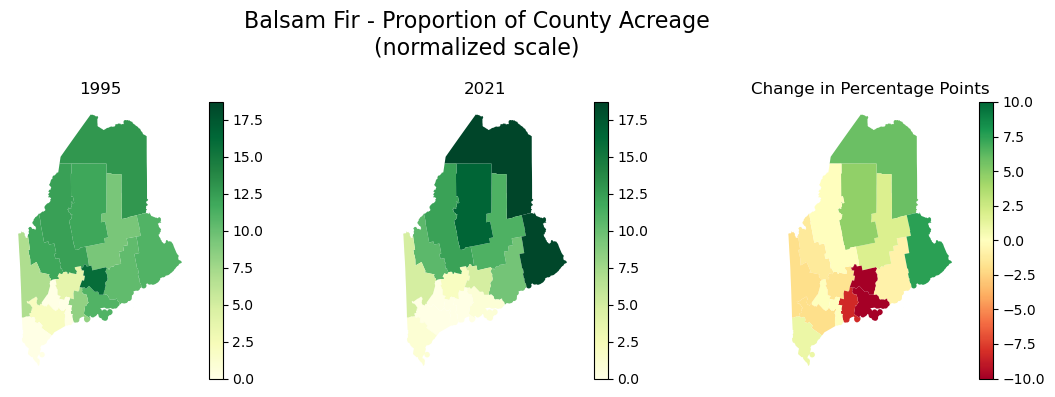

In [111]:
plot_tree_dist('Balsam Fir')

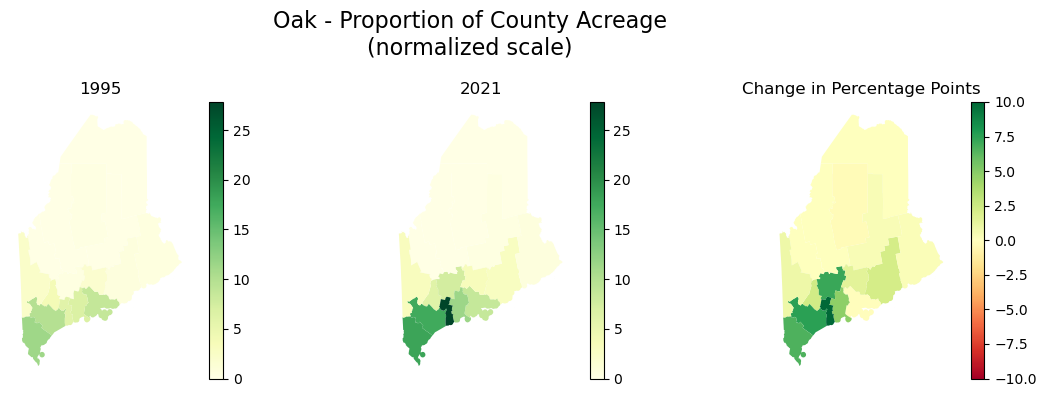

In [112]:
plot_tree_dist('Oak')

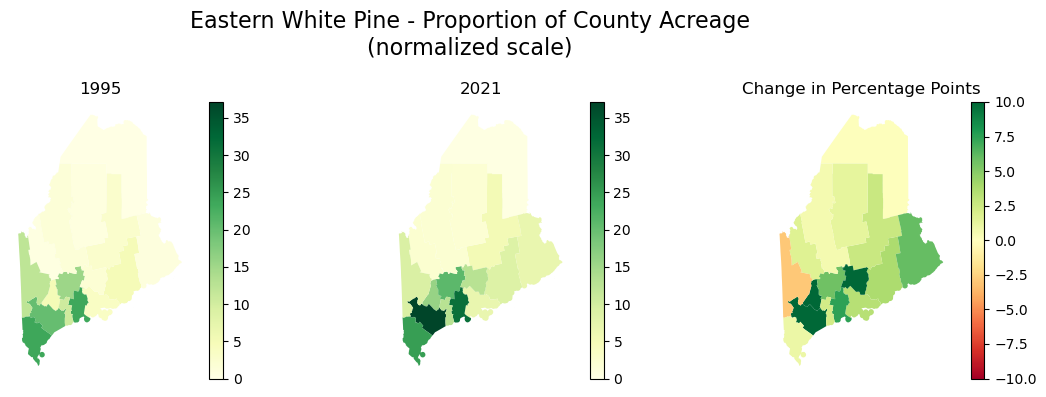

In [113]:
plot_tree_dist('Eastern White Pine')

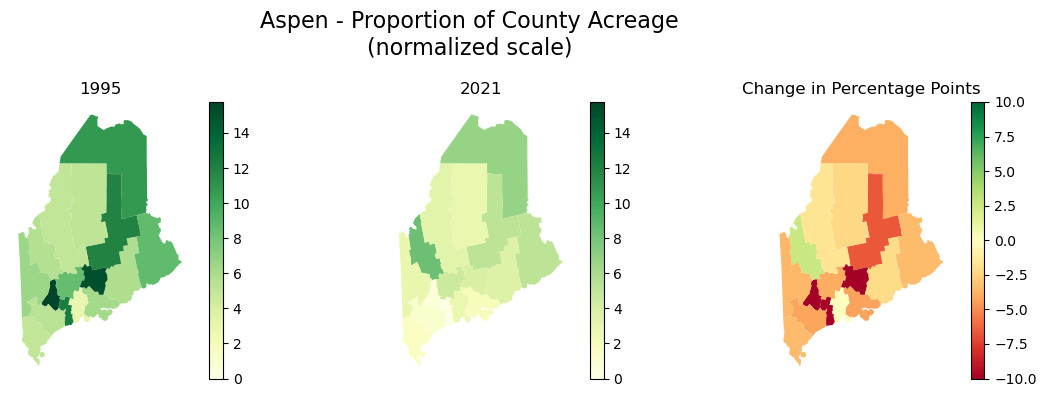

In [114]:
plot_tree_dist('Aspen')

## Conclusions

Colder adapted species such as Balsam Fir and Aspen are declining in many southern counties. Aspen has been declining throughout the state, while Balsam Fir has been 'migrating' from southern to northern counties. 

Warmer adapted species, such as Oak and Eastern White Pine are becoming more prevalent in the state. Northern counties still do not have any oak trees, but oak populations have grown in sothern counties. Eastern White Pine has also spread into more counties over time. 

This analysis suggests that the warming climate in Maine is resulting in a change in forest type from cold-adapted boreal species to temperate species. 